#Import libraries, Load dataset, Shape of data, Visualise data

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.5.0'

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.signal import convolve
from skimage import color
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, models, layers, optimizers
from sklearn import metrics

In [ ]:


from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
data = np.load('drive/My Drive/Colab Notebooks/images.npy')

In [ ]:
data.shape

(4750, 128, 128, 3)

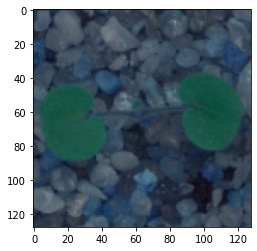

In [ ]:
plt.imshow(data[0,:,:,:])

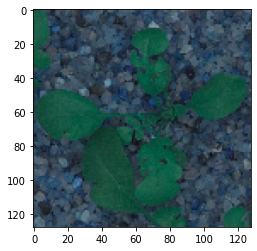

In [ ]:
plt.imshow(data[1000,:,:,:])

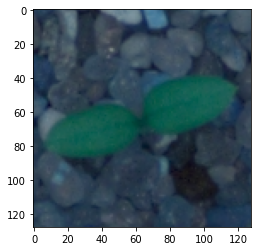

In [ ]:
plt.imshow(data[2000,:,:,:])

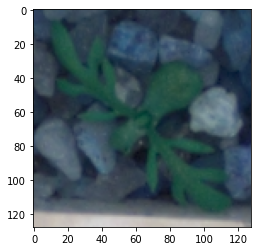

In [ ]:
plt.imshow(data[3000,:,:,:])

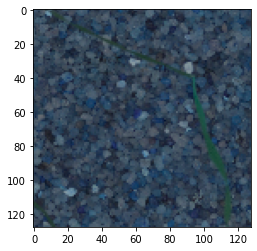

In [ ]:
plt.imshow(data[4000,:,:,:])

#Data Pre-processing

## Normalise data

In [ ]:
data = data.astype('float')

In [ ]:
data /= 255

##Converting images to grayscale

In [ ]:
imgGray = color.rgb2gray(data[0,:,:,:])
imgGray.resize([1,128,128])
data_gray = tf.concat(imgGray,0)
data_gray.shape

TensorShape([1, 128, 128])

In [ ]:
for i in range(1,4750):
  imgGray = color.rgb2gray(data[i,:,:,:])
  imgGray.resize([1,128,128])
  data_gray = tf.concat([data_gray,imgGray],0)

In [ ]:
data_gray.shape

TensorShape([4750, 128, 128])

##Gaussian blurring

In [ ]:
kernel = np.array([[0.003765,0.015019,0.023792,0.015019,0.003765],
                   [0.015019,0.059912,0.094907,0.059912,0.015019],
                   [0.023792,0.094907,0.150342,0.094907,0.023792],
                   [0.015019,0.059912,0.094907,0.059912,0.015019],
                   [0.003765,0.015019,0.023792,0.015019,0.003765]])

In [ ]:
kernel.resize([5,5])

In [ ]:
blur = convolve(data_gray[0,:,:], kernel, mode='valid')
blur_tf = tf.concat(blur,0)

In [ ]:
blur_tf = tf.expand_dims(blur_tf, 0)
blur_tf.shape

TensorShape([1, 124, 124])

In [ ]:
for i in range(1,4750):
  blur = convolve(data_gray[i,:,:], kernel, mode='valid')
  blur.resize([1,124,124])
  blur_tf = tf.concat([blur_tf,blur], 0)

blur_tf.shape

TensorShape([4750, 124, 124])

#Visualisation after blurring

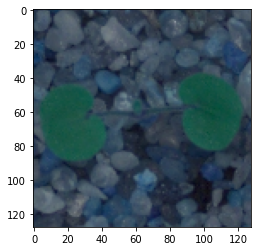

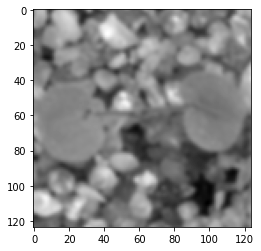

In [ ]:
plt.imshow(data[0,:,:,:])
plt.show()
plt.imshow(blur_tf[0,:,:],cmap='gray')

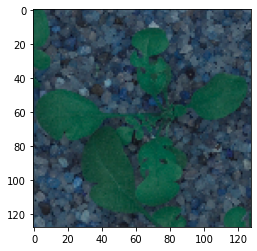

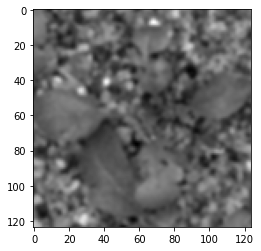

In [ ]:
plt.imshow(data[1000,:,:,:])
plt.show()
plt.imshow(blur_tf[1000,:,:],cmap='gray')

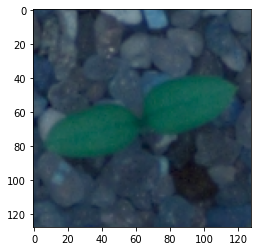

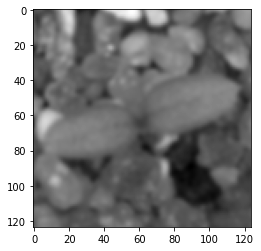

In [ ]:
plt.imshow(data[2000,:,:,:])
plt.show()
plt.imshow(blur_tf[2000,:,:],cmap='gray')

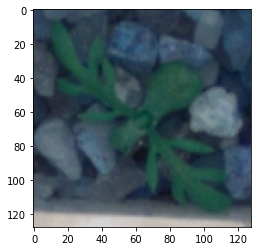

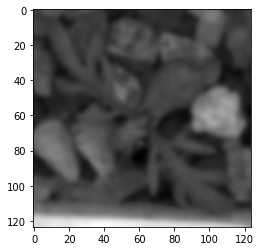

In [ ]:
plt.imshow(data[3000,:,:,:])
plt.show()
plt.imshow(blur_tf[3000,:,:],cmap='gray')

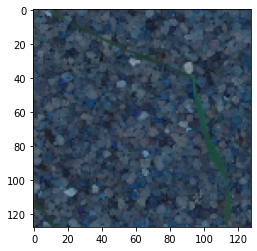

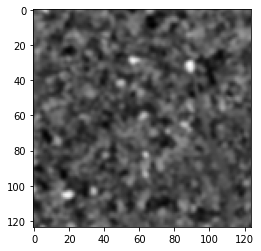

In [ ]:
plt.imshow(data[4000,:,:,:])
plt.show()
plt.imshow(blur_tf[4000,:,:],cmap='gray')

#Make data compatible

##Convert labels to one hot vectors

In [ ]:
ylabels = pd.read_csv('drive/My Drive/Colab Notebooks/Labels.csv')

In [ ]:
ylabels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

In [ ]:
ylabels = pd.get_dummies(ylabels)

ylabels

,Label_Black-grass,Label_Charlock,Label_Cleavers,Label_Common Chickweed,Label_Common wheat,Label_Fat Hen,Label_Loose Silky-bent,Label_Maize,Label_Scentless Mayweed,Label_Shepherds Purse,Label_Small-flowered Cranesbill,Label_Sugar beet
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4745,0,0,0,0,0,0,1,0,0,0,0,0
4746,0,0,0,0,0,0,1,0,0,0,0,0
4747,0,0,0,0,0,0,1,0,0,0,0,0
4748,0,0,0,0,0,0,1,0,0,0,0,0


##Print the label of ytrain[0]

In [ ]:
col = ylabels.columns.values

In [ ]:
j=-1
for i in ylabels.iloc[0]:
  j=j+1
  if i==1:
    print('The label for ytrain[0] is ', col[j])

The label for ytrain[0] is  Label_Small-flowered Cranesbill


##Split the dataset into train, test and validation

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(blur_tf, ylabels, test_size=0.3, random_state=42, stratify=ylabels)
#The above line of code generates the below error:
#TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([4163,  422,  175, ..., 4472, 2948, 3714])
#To avoid this error, original dataset is used.

In [ ]:
X_train, X_test1, y_train, y_test1 = train_test_split(data, ylabels, test_size=0.3, random_state=42, stratify=ylabels)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42, stratify=y_test1)

##Checking the shape of data

In [ ]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (3325, 128, 128, 3)
y_train:  (3325, 12)
X_val:  (712, 128, 128, 3)
y_val:  (712, 12)
X_test:  (713, 128, 128, 3)
y_test:  (713, 12)




*   The data is in compatible shape 



#Building CNN:

##Define layers

In [ ]:
batch_size = None

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

##Define optimizer and loss function

In [ ]:
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [ ]:
loss='categorical_crossentropy'

#Fit and evaluate model and print confusion matrix. 

In [ ]:
model.compile(loss=loss,
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 40


Epoch 1/40
104/104 [==============================] - 36s 36ms/step - loss: 3.2928 - accuracy: 0.2102 - val_loss: 2.4982 - val_accuracy: 0.1376
Epoch 2/40
104/104 [==============================] - 3s 28ms/step - loss: 1.7975 - accuracy: 0.3615 - val_loss: 2.7437 - val_accuracy: 0.1376
Epoch 3/40
104/104 [==============================] - 3s 28ms/step - loss: 1.5756 - accuracy: 0.4499 - val_loss: 3.0695 - val_accuracy: 0.1404
Epoch 4/40
104/104 [==============================] - 3s 29ms/step - loss: 1.4504 - accuracy: 0.5113 - val_loss: 2.1115 - val_accuracy: 0.2697
Epoch 5/40
104/104 [==============================] - 3s 28ms/step - loss: 1.3322 - accuracy: 0.5492 - val_loss: 2.7722 - val_accuracy: 0.1517
Epoch 6/40
104/104 [==============================] - 3s 28ms/step - loss: 1.2780 - accuracy: 0.5696 - val_loss: 1.7524 - val_accuracy: 0.3371
Epoch 7/40
104/104 [==============================] - 3s 28ms/step - loss: 1.1800 - accuracy: 0.6117 - val_loss: 1.4986 - val_accuracy: 0.466

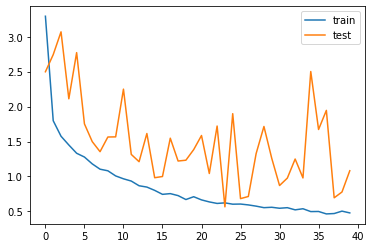

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1,
                    )

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 17ms/step - loss: 0.9772 - accuracy: 0.6816
Test loss: 0.9772440791130066
Test accuracy: 0.6816269159317017


In [ ]:
y_pred = model.predict(X_test, verbose=1)

23/23 [==============================] - 0s 8ms/step


In [ ]:
cm = metrics.confusion_matrix(y_test.values.argmax(axis=1),y_pred.argmax(axis=1))
cm

array([[ 0,  0,  0,  0,  0,  2, 33,  0,  4,  0,  0,  0],
       [ 0,  6,  5,  0,  2,  5,  0,  3,  6, 26,  4,  1],
       [ 0,  0, 15,  0,  3, 16,  0,  0,  1,  1,  7,  0],
       [ 0,  0,  0, 76,  0,  0,  0,  0, 13,  3,  0,  0],
       [ 3,  0,  0,  0, 13,  5, 12,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 64,  5,  0,  3,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  3, 92,  0,  3,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 25,  0,  0,  7,  1],
       [ 0,  0,  0,  0,  0,  0,  1,  0, 77,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 11, 22,  0,  0],
       [ 0,  0,  0,  0,  0,  4,  0,  0,  1,  2, 68,  0],
       [ 0,  0,  0,  0,  1,  3,  0,  1, 25,  0,  0, 28]])

#Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[5]

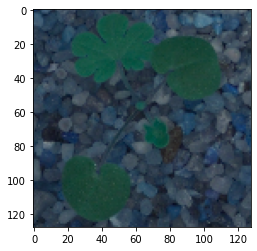

In [ ]:
plt.imshow(X_test[2,:,:,:])

In [ ]:
print('Prediction for the above image is: ', col[y_pred[2].argmax()])

Prediction for the above image is:  Label_Small-flowered Cranesbill


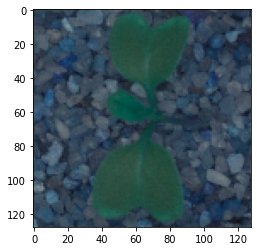

In [ ]:
plt.imshow(X_test[3,:,:,:])

In [ ]:
print('Prediction for the above image is: ', col[y_pred[3].argmax()])

Prediction for the above image is:  Label_Shepherds Purse


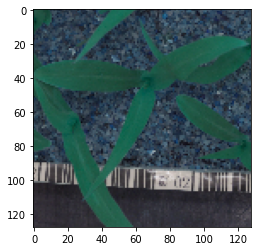

In [ ]:
plt.imshow(X_test[33,:,:,:])

In [ ]:
print('Prediction for the above image is: ', col[y_pred[33].argmax()])

Prediction for the above image is:  Label_Small-flowered Cranesbill


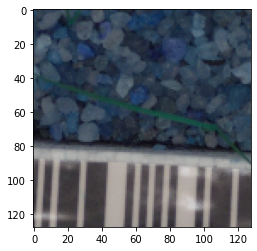

In [ ]:
plt.imshow(X_test[36,:,:,:])

In [ ]:
print('Prediction for the above image is: ', col[y_pred[36].argmax()])

Prediction for the above image is:  Label_Loose Silky-bent


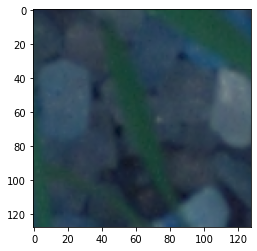

In [ ]:
plt.imshow(X_test[5,:,:,:])

In [ ]:
print('Prediction for the above image is: ', col[y_pred[5].argmax()])

Prediction for the above image is:  Label_Fat Hen


In [ ]:
%%shell
jupyter nbconvert --to html /content/Computer_Vision_Plant_Seedlings_Image_Classification_using_CNNs_in_Keras.ipynb

[NbConvertApp] Converting notebook /content/Computer_Vision_Plant_Seedlings_Image_Classification_using_CNNs_in_Keras.ipynb to html
[NbConvertApp] Writing 2177245 bytes to /content/Computer_Vision_Plant_Seedlings_Image_Classification_using_CNNs_in_Keras.html
